In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.spatial import ConvexHull

# File path to read from
file_path = 'data.csv'

# Arrays to hold the data
temps = []
position = []


# Reading the data
with open(file_path, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        temps.append(float(row[0]))
        position.append(float(row[1]))

print("Time:", temps)
print("Position:", position)

Time: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.

In [2]:


import numpy as np

# Constantes
M = 70000  # kg
g = 9.81  # m/s²
A0, A1 = 780, 6.4  # N, N/tonne
B0, B1 = 0, 0.14  # N, N/tonne/(km/h)
C0, C1 = 0.3634, 0  # N/(km/h)²
eta_motor = 0.8  # Rendement moteur
eta_battery = 0.9  # Rendement batterie
P_aux = 35000  # W

# Paramètres réseau
V_sst = 790  # V
R_sst = 33e-3  # Ohms
rho_LAC = 95e-6  # Ohms/m
rho_rail = 10e-6  # Ohms/m

# Données de position-temps
t = np.array(temps)  # secondes
position = np.array(position)  # mètres

# Calcul des grandeurs mécaniques
v = np.gradient(position, t)  # m/s
a = np.gradient(v, t)  # m/s²
alpha = 0  # radians

# Résistance à l'avancement
F_resistive = (A0 + A1 * (M / 1000)) + (B0 + B1 * (M / 1000) * v * 3.6) + (C0 + C1 * (M / 1000) * (v * 3.6)**2)

# Force motrice
F_motrice = M * a + M * g * np.sin(alpha) + F_resistive


# Puissance mécanique
P_mec = F_motrice * v  # En watts

# Puissance totale demandée

#P_train = P_mec / eta_motor + P_aux  # En watts

P_train = [
    (P / eta_motor + P_aux) if P >= 0 else (P * eta_motor + P_aux)
    for P in P_mec
]


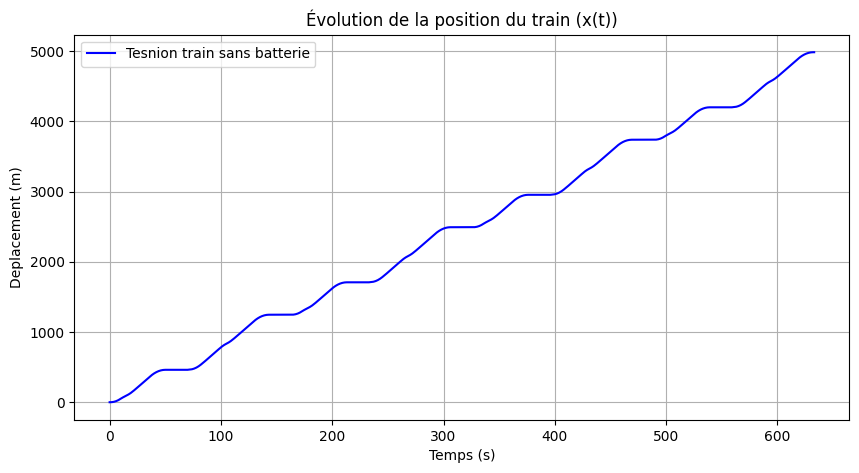

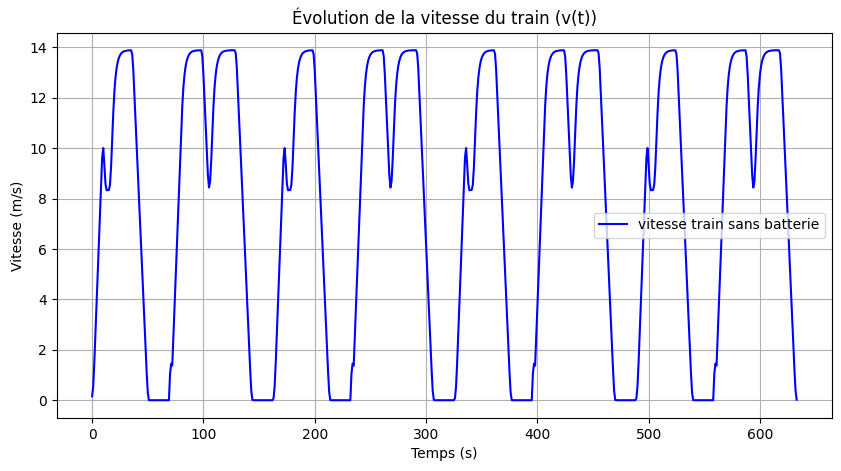

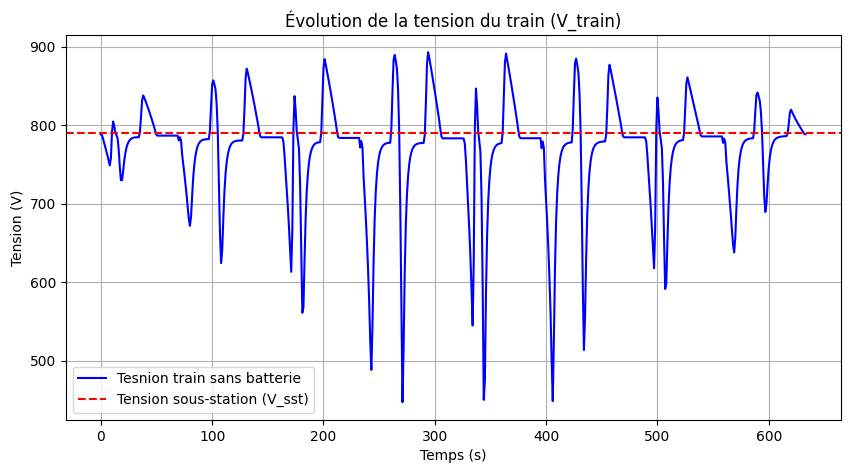

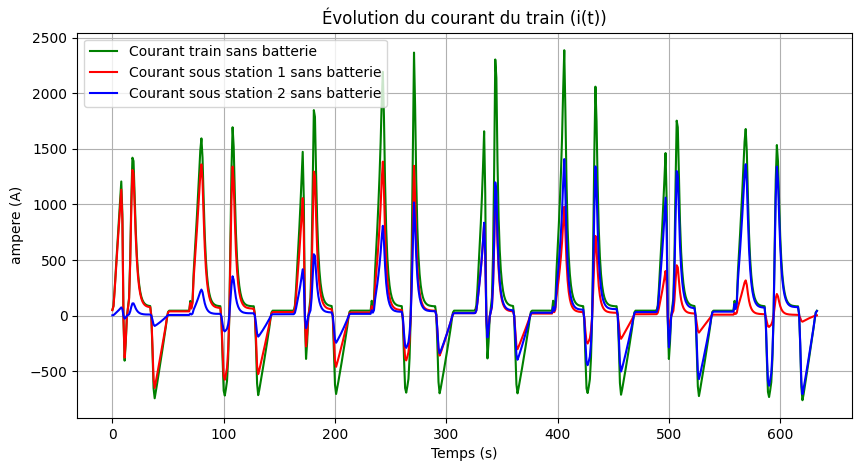

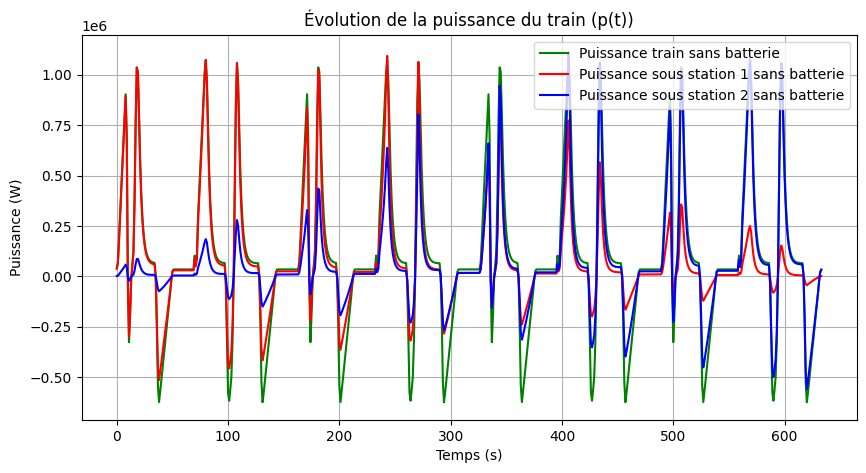

In [3]:
# --- Simulation sans batterie ---
V_train_no_batt = []
I_train = []
I_1 = []
I_2 = []
Psst_1 = []
Psst_2 = []

for i in range(len(temps)):
    # Résistances des segments de LAC et rail
    R_LAC1 = rho_LAC * position[i]  # Jusqu'au train
    R_LAC2 = rho_LAC * (5000 - position[i])  # Après le train
    R_rail1 = rho_rail * position[i]
    R_rail2 = rho_rail * (5000 - position[i])
    R_eq1=(R_sst + R_LAC1 + R_rail1)
    R_eq2=(R_sst + R_LAC2 + R_rail2)
    # Résistance équivalente (Req)
    R_eq = 1 / (1 / R_eq1 + 1 / R_eq2)
    # Calcul de la tension V_train à partir de l'équation quadratique

    delta = V_sst**2 - 4 * R_eq * P_train[i]
    if delta >= 0:
        V_train = 0.5 * (V_sst + np.sqrt(delta))
    else:
        V_train = np.NaN  # Cas où la tension est impossible

    V_train_no_batt.append(V_train)

    I_train.append((V_sst-V_train)/R_eq)
    I_1.append((V_sst-V_train)/R_eq*(R_eq2/(R_eq2+R_eq1)))
    I_2.append((V_sst-V_train)/R_eq*(R_eq1/(R_eq2+R_eq1)))

I_train=np.array(I_train)
I_1=np.array(I_1)
I_2=np.array(I_2)
# calcule des autres grandeurs:

Psst_1 = I_1 * V_sst
Psst_2 = I_2 * V_sst

# --- Tracé des résultats ---



# position
plt.figure(figsize=(10, 5))
plt.figure(1)
plt.plot(t, position, label="Tesnion train sans batterie", color="blue")
plt.xlabel("Temps (s)")
plt.ylabel("Deplacement (m)")
plt.title("Évolution de la position du train (x(t))")
plt.legend()
plt.grid()

# Vitesse
plt.figure(figsize=(10, 5))
plt.figure(2)
plt.plot(t, v, label="vitesse train sans batterie", color="blue")
plt.xlabel("Temps (s)")
plt.ylabel("Vitesse (m/s)")
plt.title("Évolution de la vitesse du train (v(t))")
plt.legend()
plt.grid()

# Tensions
plt.figure(figsize=(10, 5))
plt.figure(3)
plt.plot(t, V_train_no_batt, label="Tesnion train sans batterie", color="blue")
plt.axhline(V_sst, color="red", linestyle="--", label="Tension sous-station (V_sst)")
plt.xlabel("Temps (s)")
plt.ylabel("Tension (V)")
plt.title("Évolution de la tension du train (V_train)")
plt.legend()
plt.grid()

# courants
plt.figure(figsize=(10, 5))
plt.figure(4)
plt.plot(t, I_train, label="Courant train sans batterie", color="green")
plt.plot(t, I_1, label="Courant sous station 1 sans batterie", color="red")
plt.plot(t, I_2, label="Courant sous station 2 sans batterie", color="blue")
plt.xlabel("Temps (s)")
plt.ylabel("ampere (A)")
plt.title("Évolution du courant du train (i(t))")
plt.legend()
plt.grid()

# puissances
plt.figure(figsize=(10, 5))
plt.figure(5)
plt.plot(t, P_train, label="Puissance train sans batterie", color="green")
plt.plot(t, Psst_1, label="Puissance sous station 1 sans batterie", color="red")
plt.plot(t, Psst_2, label="Puissance sous station 2 sans batterie", color="blue")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (W)")
plt.title("Évolution de la puissance du train (p(t))")
plt.legend()
plt.grid()



In [4]:
# --- Simulation avec batterie ---
# Batterie
def batterie_simulation(C_batt, P_batt_max, P_seuil, position, temps):
    """
    Simule le fonctionnement du train avec une batterie en utilisant des variables globales pour le contexte.

    Paramètres:
        C_batt (float): Capacité de la batterie en joules.
        P_batt_max (float): Puissance maximale de charge/décharge de la batterie (W).
        Seuil (float): Seuil de puissance apartir du quel on commence a consommé l'energie depuis la batterie
        K(float): relation entre le cout et la capacité de la batterie
        position (list): Liste des positions du train (m).
        temps (list): Liste des instants de temps (s).


    Retourne:
        V_train_with_batt (list): Tension du train avec la batterie (V).
        E_batt_history (list): Historique de l'énergie de la batterie (J).
        Cout_batt (float): cout de la batterie
        Delta_Vmax (float): la plus grande shute de tension

    """

    E_batt_max = C_batt  # Énergie initiale de la batterie (joules)
    P_batt = [0]
    V_train_with_batt = [790]
    E_batt_history = [E_batt_max]
    P_LAC = []  # Initialisation de P_LAC comme une liste vide
    P_rheostat = []  # Initialisation de P_rheostat comme une liste vide
    I_train=[]
    I_1=[]
    I_2=[]
    for i in range(1, len(temps)):
        delta_t = temps[i] - temps[i-1]  # Le pas de temps (1s ici, mais il peut être ajusté)
        # Résistances des segments de LAC et rail
        R_LAC1 = rho_LAC * position[i]  # Jusqu'au train
        R_LAC2 = rho_LAC * (5000 - position[i])  # Après le train
        R_rail1 = rho_rail * position[i]
        R_rail2 = rho_rail * (5000 - position[i])

        if P_train[i] <= 0:  # Le train freine
            if E_batt_history[-1] < E_batt_max:  # Batterie pas pleine
                P_batt.append(max(P_train[i], -P_batt_max))  # Recharge dans la limite de P_batt_max the absolute value !! # j'en doute !!
                E_batt_history.append(min(E_batt_max, E_batt_history[-1] - P_batt[-1] * delta_t))  # Mise à jour de l'énergie de la batterie
                P_rheostat.append(P_batt[-1] - P_train[i]) # Le reste va au rhéostat because we have p train <0

            else:  # Batterie pleine
                P_batt.append(0)
                P_rheostat.append(-P_train[i])  # Toute l'énergie va au rhéostat
                E_batt_history.append(E_batt_history[-1])
            P_LAC.append(0)  # Pas de demande à la LAC pendant le freinage

        elif P_train[i]>P_seuil:  # Le train accélère
            if E_batt_history[-1] > 0:  # Batterie pas vide
                P_batt.append(P_train[i] -  P_seuil)  # Limite la puissance fournie par la batterie j'en doute
                E_batt_history.append(max(0, E_batt_history[-1] - P_batt[-1] * delta_t))  # Mise à jour de l'énergie de la batterie
                P_LAC.append(P_seuil)  # Complément demandé à la LAC

            else:  # Batterie vide
                P_batt.append(0)
                E_batt_history.append(E_batt_history[-1])  # Pas d'énergie supplémentaire, la batterie reste à zéro
                P_LAC.append(P_train[i])  # Toute l'énergie vient de la LAC
        else :
            P_batt.append(0)
            E_batt_history.append(E_batt_history[-1])  # Pas d'énergie supplémentaire, la batterie reste à zéro
            P_LAC.append(P_train[i])  # Toute l'énergie vient de la LAC


        # Calcul de la tension V_train
        R_eq = 1 / (1 / (R_sst + R_LAC1 + R_rail1) + 1 / (R_sst + R_LAC2 + R_rail2))  # Calcul de R_eq
        delta = V_sst**2 - 4 * R_eq * P_LAC[-1]  # Calcul du discriminant pour la tension

        if delta > 0:
            V_train = 0.5 * (V_sst + np.sqrt(delta))  # Calcul de la tension
        else:
            V_train = np.nan  # Cas où la tension est impossible
            print (1)


        V_train_with_batt.append(V_train)  # Stocke la tension à chaque instant
        I_train.append((V_sst-V_train)/R_eq)
        I_1.append((V_sst-V_train)/R_eq*(R_eq2/(R_eq2+R_eq1)))
        I_2.append((V_sst-V_train)/R_eq*(R_eq1/(R_eq2+R_eq1)))
        I_train.append((V_sst-V_train)/R_eq)



        # Correction de l'ajout final
    if len(V_train_with_batt) < len(t):
        V_train_with_batt.append(V_train_with_batt[-1])  # Ajout de la dernière valeur de la tension


    Delta_Vmax=V_sst-np.min(V_train_with_batt)
    cout_batt=C_batt # le coût est proportionnelle à la capacité de batterie


    return V_train_with_batt, E_batt_history, Delta_Vmax, cout_batt


def plot_simulation_results():

    # --- Tracé des résultats ---
    print("Longueur de t:", len(t))
    print("Longueur de V_train_no_batt:", len(V_train_no_batt))
    print("Longueur de V_train_with_batt:", len(V_train_with_batt))
    print("Longueur E_batt_history :", len(E_batt_history))

    assert len(t) == len(V_train_no_batt), f"Erreur : longueur de t ({len(t)}) et de V_train_no_batt ({len(V_train_no_batt)}) ne sont pas égales."
    assert len(t) == len(V_train_with_batt), f"Erreur : longueur de t ({len(t)}) et de V_train_with_batt ({len(V_train_with_batt)}) ne sont pas égales."
    # Tensions
    plt.figure(7)
    plt.figure(figsize=(14, 8))
    #plt.plot(t, V_train_no_batt, label="Sans batterie", color="blue")
    plt.plot(t, V_train_with_batt, label="Avec batterie", color="green")
    plt.axhline(V_sst, color="red", linestyle="--", label="Tension sous-station (V_sst)")
    plt.xlabel("Temps (s)")
    plt.ylabel("Tension (V)")
    plt.title("Évolution de la tension du train (V_train)")
    plt.legend()
    plt.grid()

    # puissances

    plt.figure(8)
    plt.figure(figsize=(14, 8))
    plt.plot(t, P_train, label="Puissance train sans batterie", color="green")
    plt.xlabel("Temps (s)")
    plt.ylabel("Puissance (W)")
    plt.title("Évolution de la puissance du train (p(t))")
    plt.legend()
    plt.grid()

    # Énergie de la batterie
    plt.figure(6)
    plt.figure(figsize=(14, 8))
    plt.plot(t, np.array(E_batt_history) / 1e6, label="Énergie de la batterie (MJ)", color="orange")
    plt.xlabel("Temps (s)")
    plt.ylabel("Énergie (MJ)")
    plt.title("Évolution de l'énergie de la batterie")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # courant
    plt.figure(figsize=(10, 5))
    plt.figure(7)
    plt.plot(t, I_train, label="Courant train sans batterie", color="green")
    plt.plot(t, I_1, label="Courant sous station 1 sans batterie", color="red")
    plt.plot(t, I_2, label="Courant sous station 2 sans batterie", color="blue")
    plt.xlabel("Temps (s)")
    plt.ylabel("ampere (A)")
    plt.title("Évolution du courant du train (i(t))")
    plt.legend()
    plt.grid()


Longueur de t: 634
Longueur de V_train_no_batt: 634
Longueur de V_train_with_batt: 634
Longueur E_batt_history : 634


<Figure size 640x480 with 0 Axes>

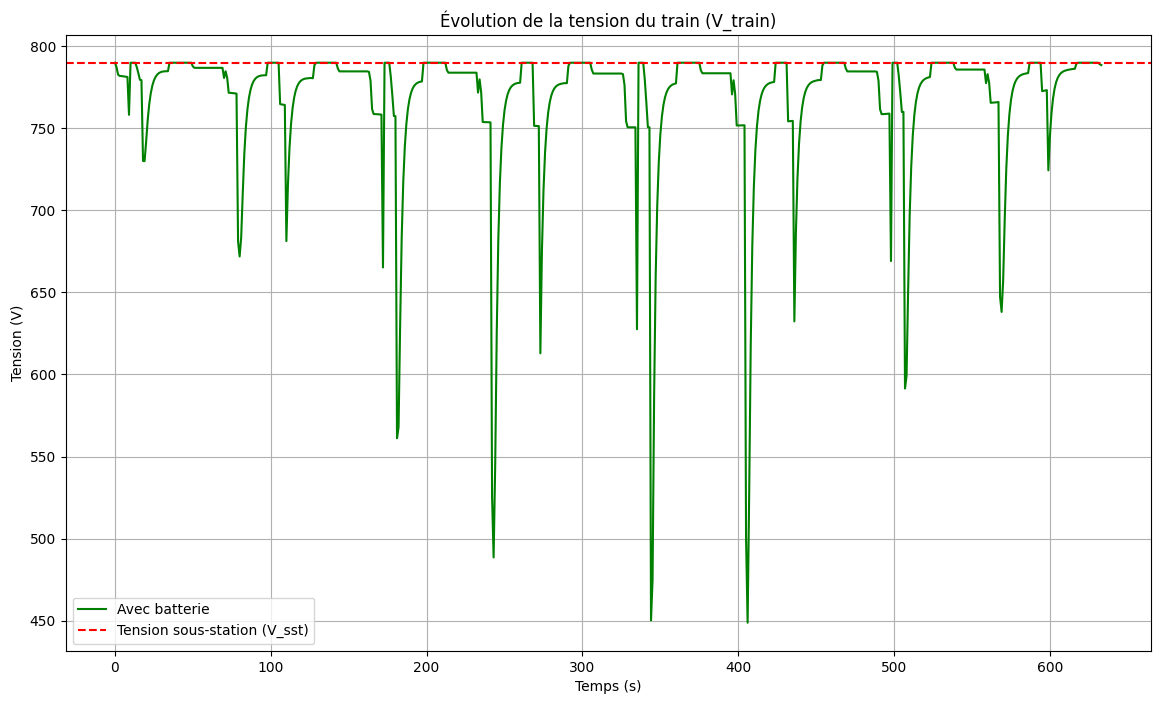

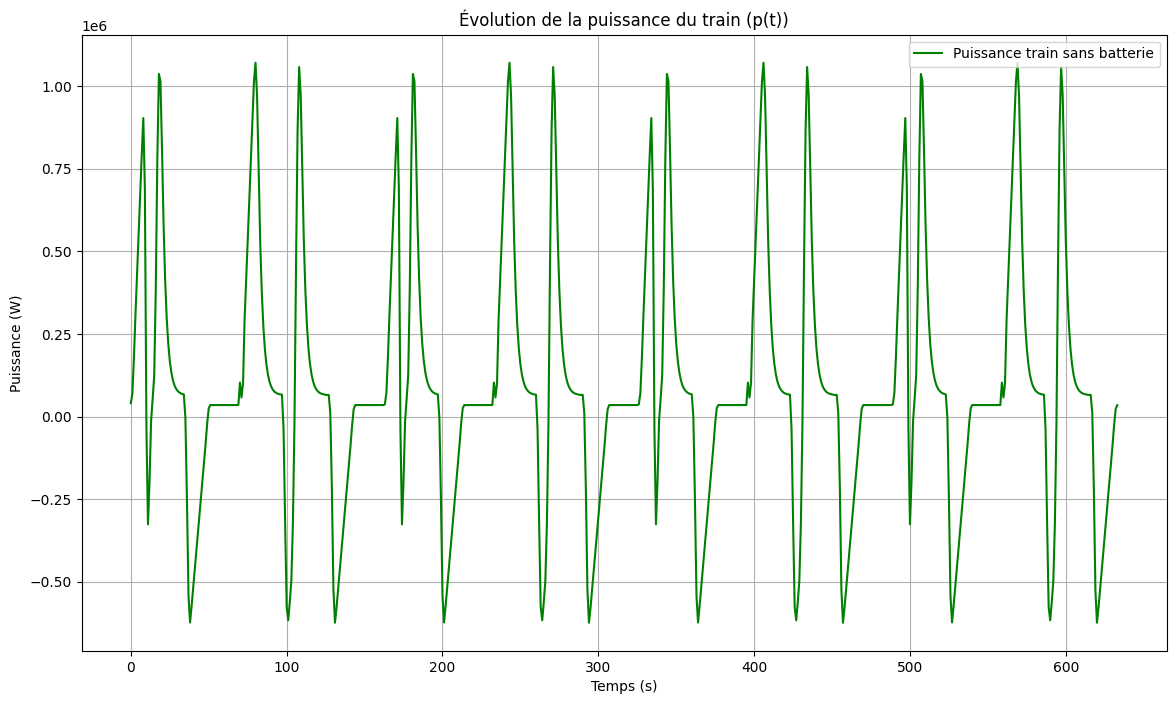

<Figure size 640x480 with 0 Axes>

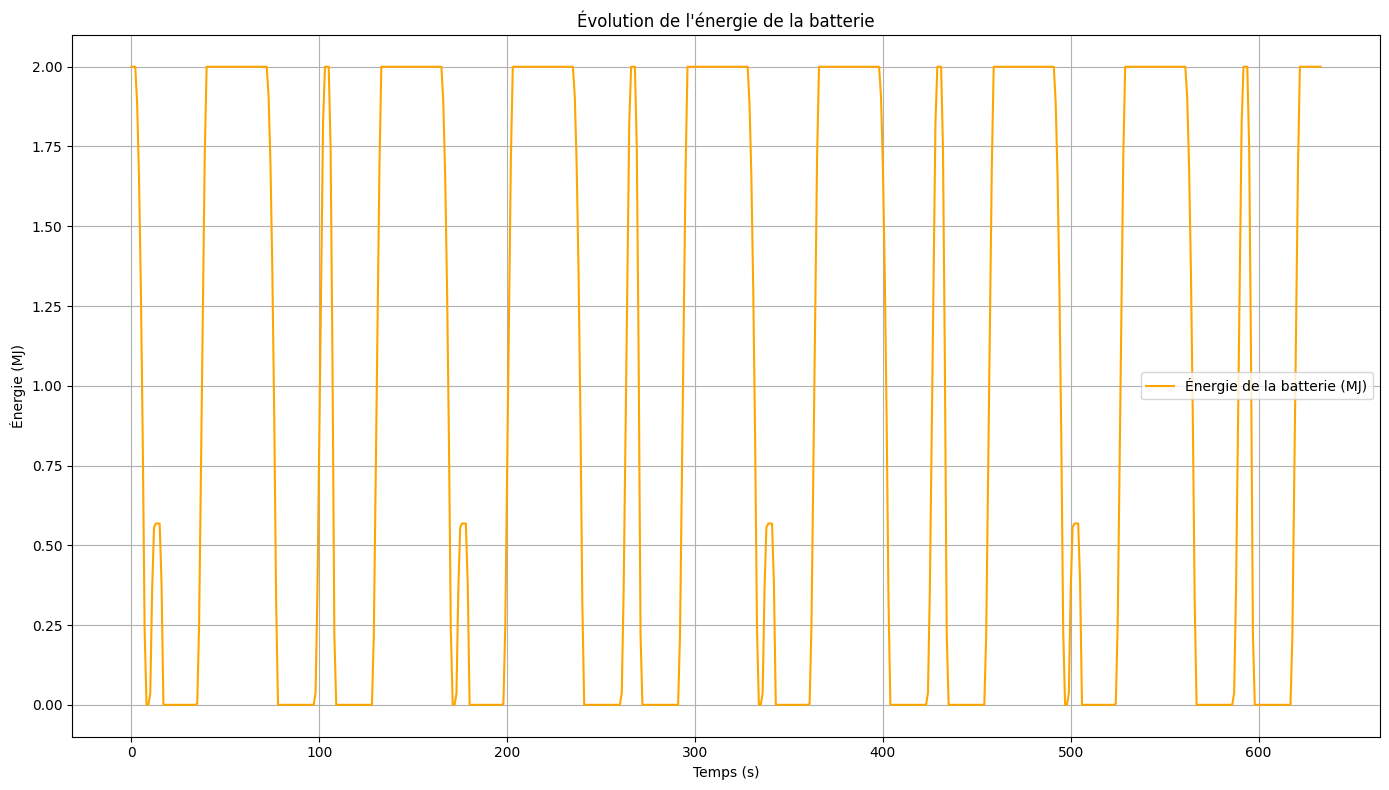

<Figure size 1000x500 with 0 Axes>

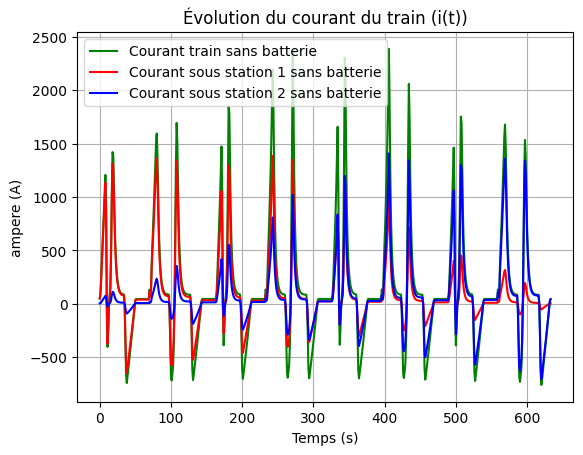

In [5]:
[V_train_with_batt, E_batt_history, Delta_Vmax ,cout_batt]= batterie_simulation(2e6, 490e3, 3e5, position, temps)
plot_simulation_results()

# Monté Carlo


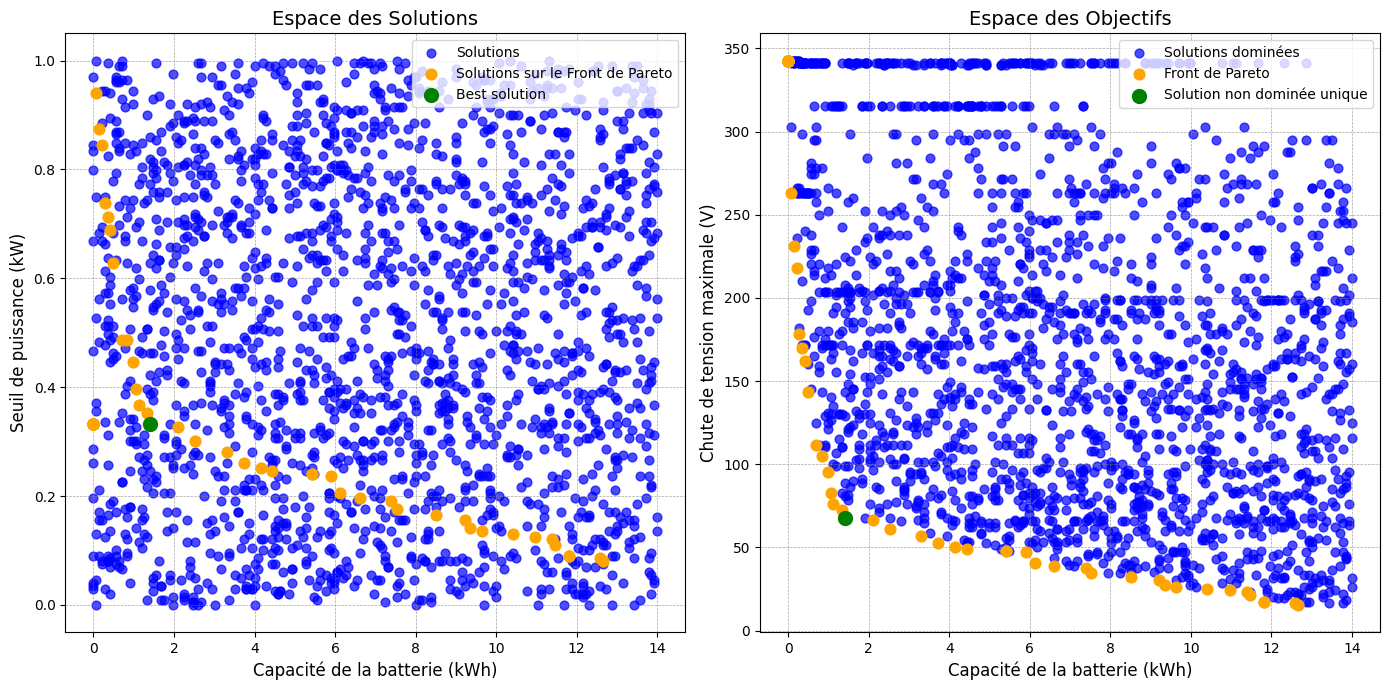

In [69]:

# Définir les plages de recherche pour la capacité de la batterie (en kWh) et le seuil de puissance (en kW)
capacite_batterie_range = np.linspace(0, 14, 200)  # Plage de capacité de batterie de 0 à 14Kwh
seuil_puissance_range = np.linspace(0, 1, 200)  # Plage du seuil de puissance de 0 à 1 MW

# Générer un échantillon aléatoire de points dans l'espace des solutions
sample_size = 2000
capacite_batterie_samples = np.random.choice(capacite_batterie_range, sample_size)
seuil_puissance_samples = np.random.choice(seuil_puissance_range, sample_size)

# Fonction de simulation pour chaque combinaison de capacité et de seuil
def simulation(capacite_batterie, seuil_puissance):
    # Appeler la fonction de simulation qui calcule la chute de tension et le coût de la batterie
    # Exemple : (Delta_Vmax, cout_batt)
    _,_,Delta_Vmax,_ = batterie_simulation(capacite_batterie * 3600000, P_batt_max=4.5e5, P_seuil=seuil_puissance*10**6, position=position, temps=temps)
   
    return Delta_Vmax , capacite_batterie

# Calcul des objectifs pour chaque échantillon
objectfs_space = [simulation(capacite, seuil) for capacite, seuil in zip(capacite_batterie_samples, seuil_puissance_samples)]
solution_space = [    capacite_batterie_samples ,seuil_puissance_samples]

# Enlever les valeurs où il y a un Nan sur la capacité de la batterie
Delta_Vmax_values = []
capacite_batterie_values = []
for V,C in objectfs_space:
  if not np.isnan(V):
    Delta_Vmax_values.append(V)
    capacite_batterie_values.append(C)

# Empiler les résultats sous forme de coordonnées (coût, chute de tension)
objectfs_space = np.array(list(zip(capacite_batterie_values, Delta_Vmax_values)))

# Fonction pour vérifier si une solution est dominée
def est_dominée(point, autres_points):
    for autre in autres_points:
        # Si l'autre solution est meilleure ou égale dans les deux objectifs,
        # et stricte dans un objectif, la solution 'point' est dominée
        if (autre[0] <= point[0] and autre[1] <= point[1]) and (autre[0] < point[0] or autre[1] < point[1]):
            return True
    return False

# Trouver les solutions non dominées
solutions_non_dominées = []

for point in objectfs_space:
    if not est_dominée(point, objectfs_space):
        solutions_non_dominées.append(point)


# Convertir la liste en un tableau numpy pour une manipulation facile
solutions_non_dominées = np.array(solutions_non_dominées)
# Trouver la solution optimale non dominée (celle qui minimise les deux objectifs)
# solution_non_dominée_unique = solutions_non_dominées[np.argmin(solutions_non_dominées[:, 0]+ solutions_non_dominées[:, 1])]

def find_best_pareto_solution(pareto_front):
    """
    Normalize the Pareto front and find the best solution based on Euclidean distance from the origin.

    Parameters:
        pareto_front (numpy.ndarray): A 2D array with Pareto front points. Each row is a solution [x, y].

    Returns:
        tuple: The best solution (original scale) and its normalized distance.
    """
    # Normalize the x and y coordinates
    x_min, x_max = pareto_front[:, 0].min(), pareto_front[:, 0].max()
    y_min, y_max = pareto_front[:, 1].min(), pareto_front[:, 1].max()

    pareto_front_normalized = np.zeros_like(pareto_front)
    pareto_front_normalized[:, 0] = (pareto_front[:, 0] - x_min) / (x_max - x_min)
    pareto_front_normalized[:, 1] = (pareto_front[:, 1] - y_min) / (y_max - y_min)

    # Find the best solution based on normalized distance
    best_index = 0
    dis_min = np.sqrt(pareto_front_normalized[0, 0]**2 + pareto_front_normalized[0, 1]**2)
    for i, pf_norm in enumerate(pareto_front_normalized):
        distance = np.sqrt(pf_norm[0]**2 + pf_norm[1]**2)  # Normalized Euclidean distance
        if distance < dis_min:
            best_index = i
            dis_min = distance

    best_solution = pareto_front[best_index]

    return best_solution


solution_non_dominée_unique = find_best_pareto_solution(solutions_non_dominées)



# Find the corresponding points in the solution space
pareto_solutions = []
for pf in solutions_non_dominées:
    for i in range(sample_size):
        if (objectfs_space[i][0] == pf[0]) and (objectfs_space[i][1] == pf[1]):  # Match in objective space
            pareto_solutions.append([solution_space[0][i], solution_space[1][i]])  # Add solution space point
            break

# Find the corresponding points in the solution space
best_solution = []

for i in range(sample_size):
    if (objectfs_space[i][0] == solution_non_dominée_unique[0]) and (objectfs_space[i][1] == solution_non_dominée_unique[1]):  # Match in objective space
        best_solution=[solution_space[0][i], solution_space[1][i]]  # Add solution space point
        break


pareto_solutions = np.array(pareto_solutions)

plt.figure(figsize=(14, 7))

# --- Plot 1: Space of Solutions ---
plt.subplot(1, 2, 1)
plt.scatter(solution_space[0], solution_space[1], color='blue', alpha=0.7,s=40, label="Solutions")
plt.scatter(pareto_solutions[:, 0], pareto_solutions[:, 1], color='orange', s=60, label="Solutions sur le Front de Pareto", zorder=5)
plt.scatter(best_solution[0], best_solution[1], color='green', label="Best solution", s=100, zorder=5)

plt.xlabel("Capacité de la batterie (kWh)", fontsize=12)
plt.ylabel("Seuil de puissance (kW)", fontsize=12)
plt.title("Espace des Solutions", fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc="upper right", fontsize=10)  # Legend always in the top-right corner

# --- Plot 2: Space of Objectives ---
plt.subplot(1, 2, 2)
plt.scatter(objectfs_space[:, 0], objectfs_space[:, 1], color='blue', alpha=0.7,s=40, label="Solutions dominées")
plt.scatter(solutions_non_dominées[:, 0], solutions_non_dominées[:, 1], color='orange',s=60, label="Front de Pareto", zorder=5)
plt.scatter(solution_non_dominée_unique[0], solution_non_dominée_unique[1], color='green', label="Solution non dominée unique", s=100, zorder=5)

plt.xlabel("Capacité de la batterie (kWh)", fontsize=12)
plt.ylabel("Chute de tension maximale (V)", fontsize=12)
plt.title("Espace des Objectifs", fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc="upper right", fontsize=10)  # Legend always in the top-right corner

plt.tight_layout()
plt.show()



# Algo Génitique

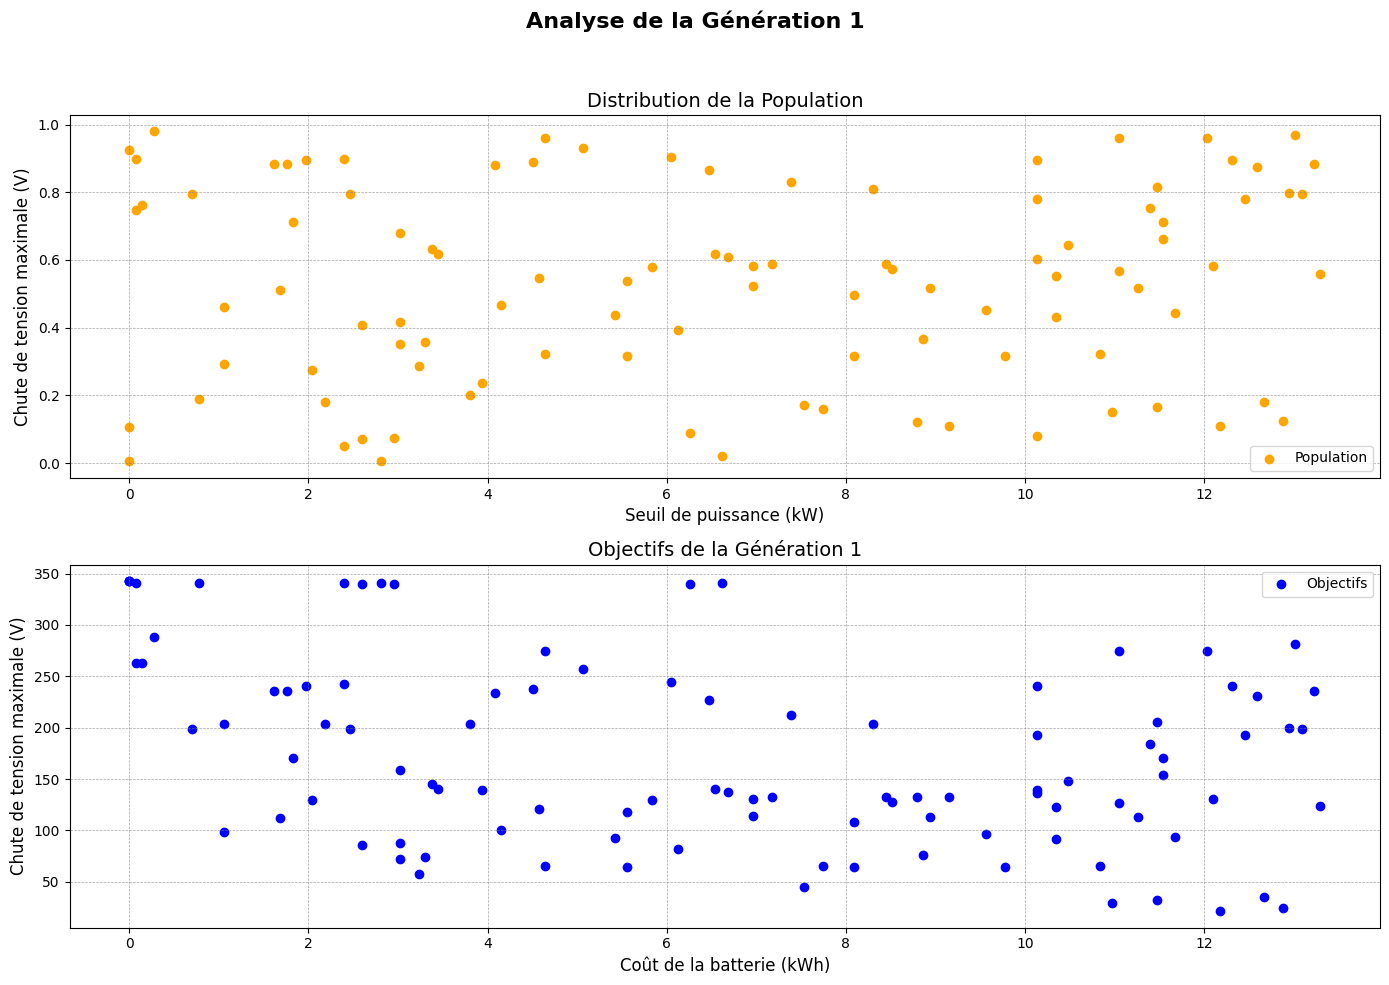

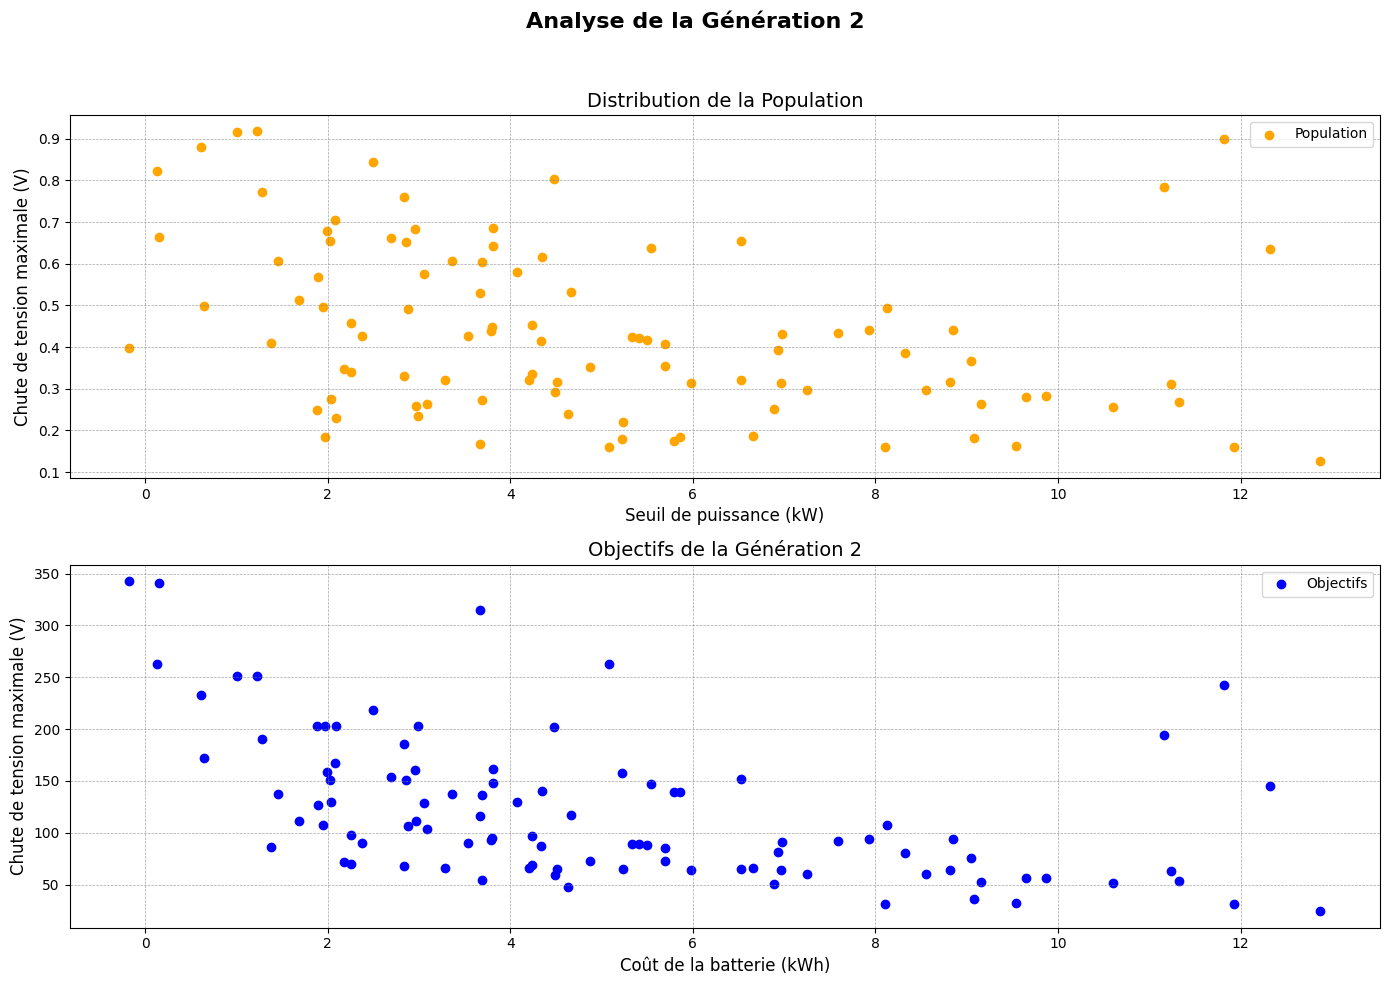

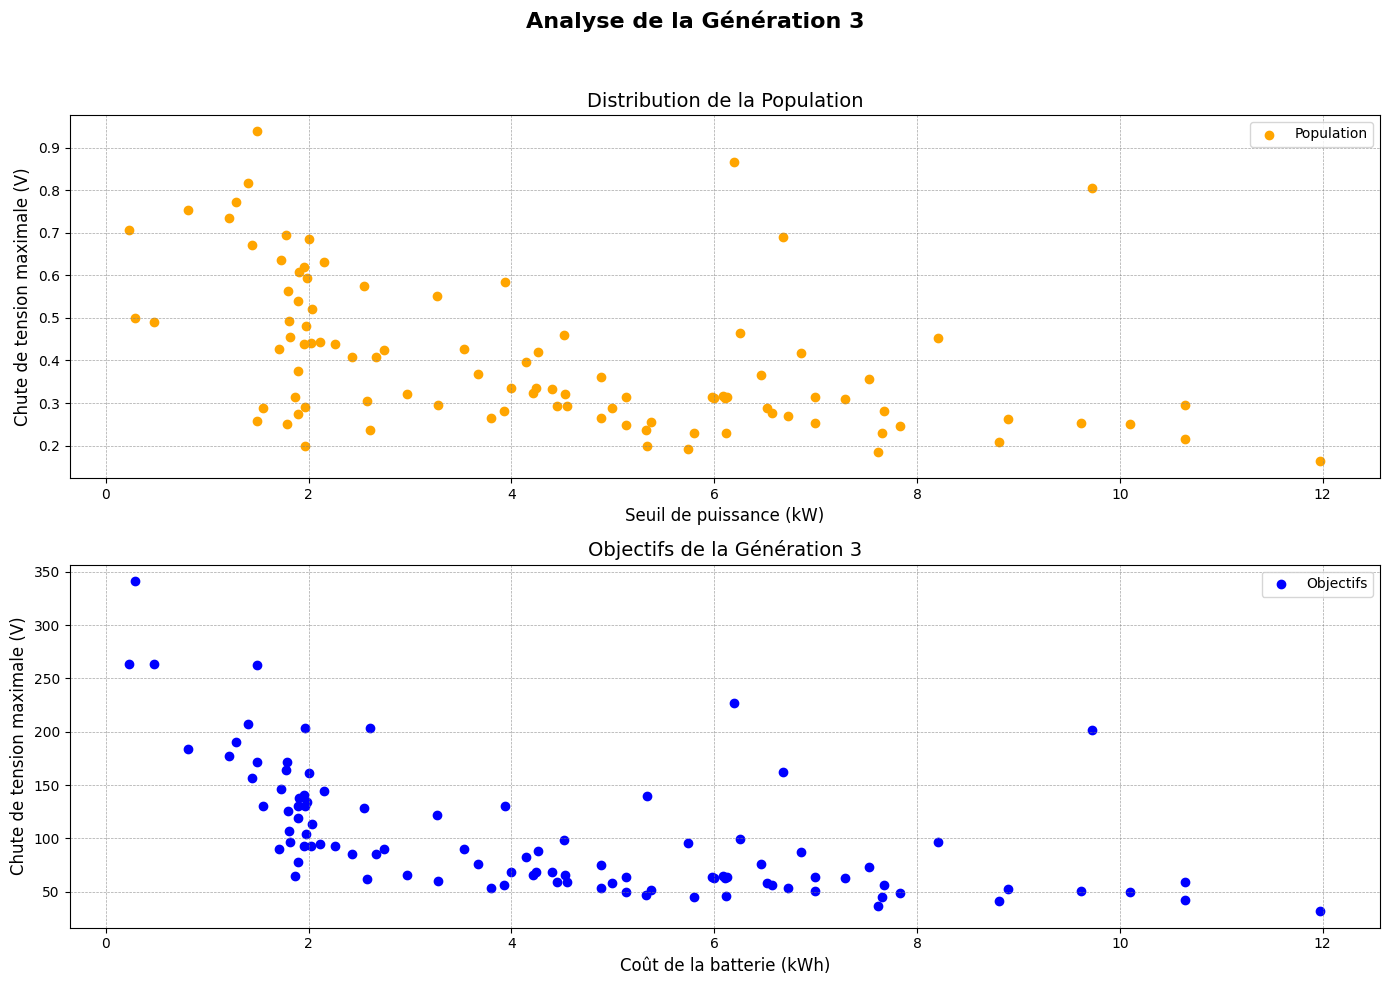

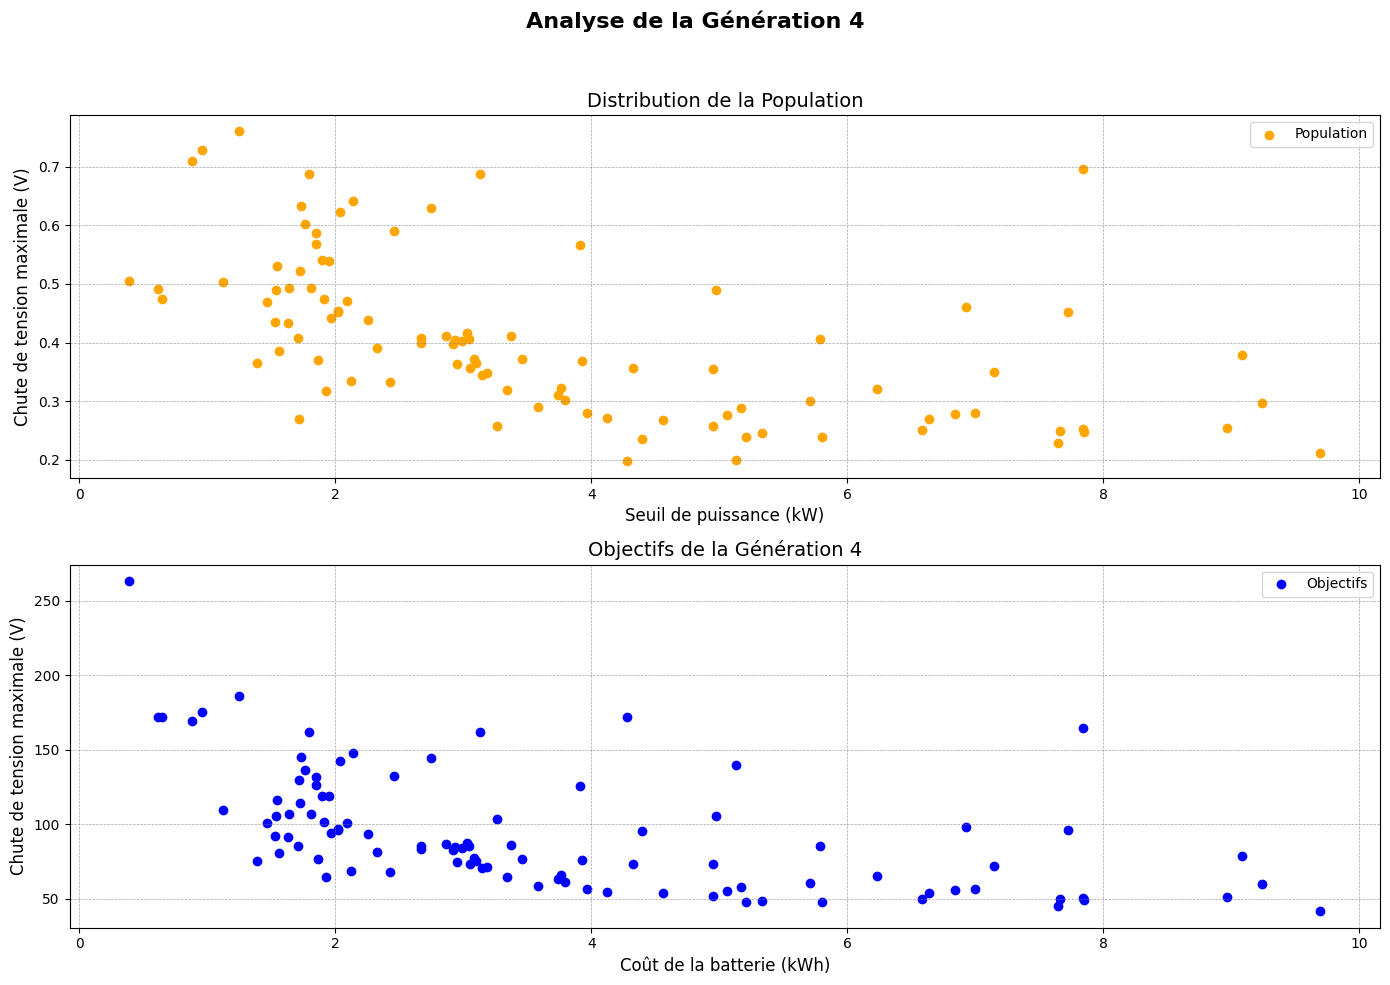

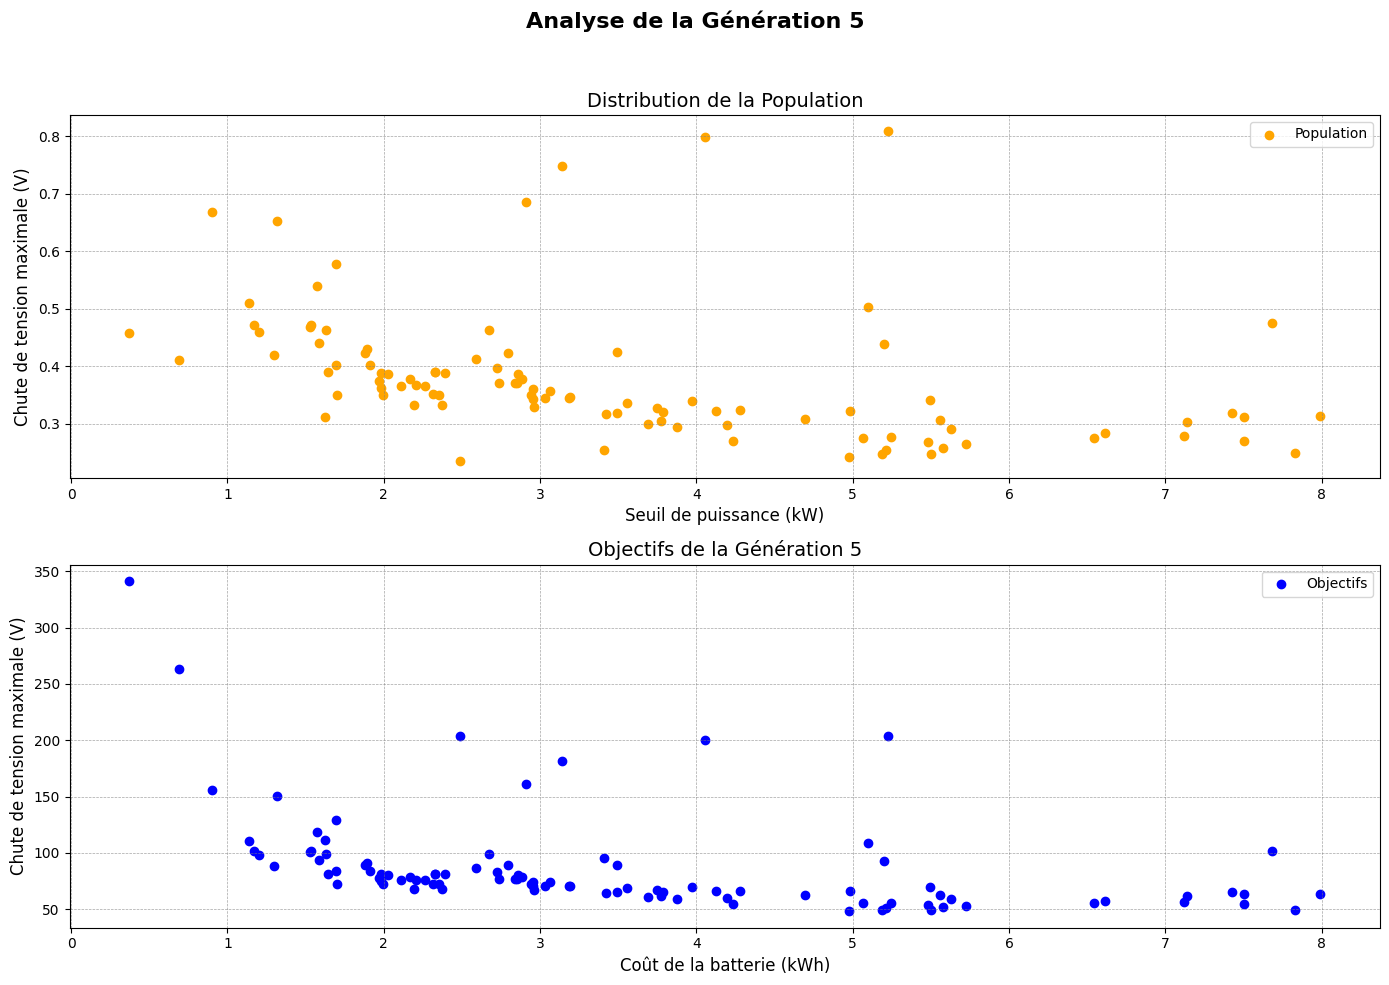

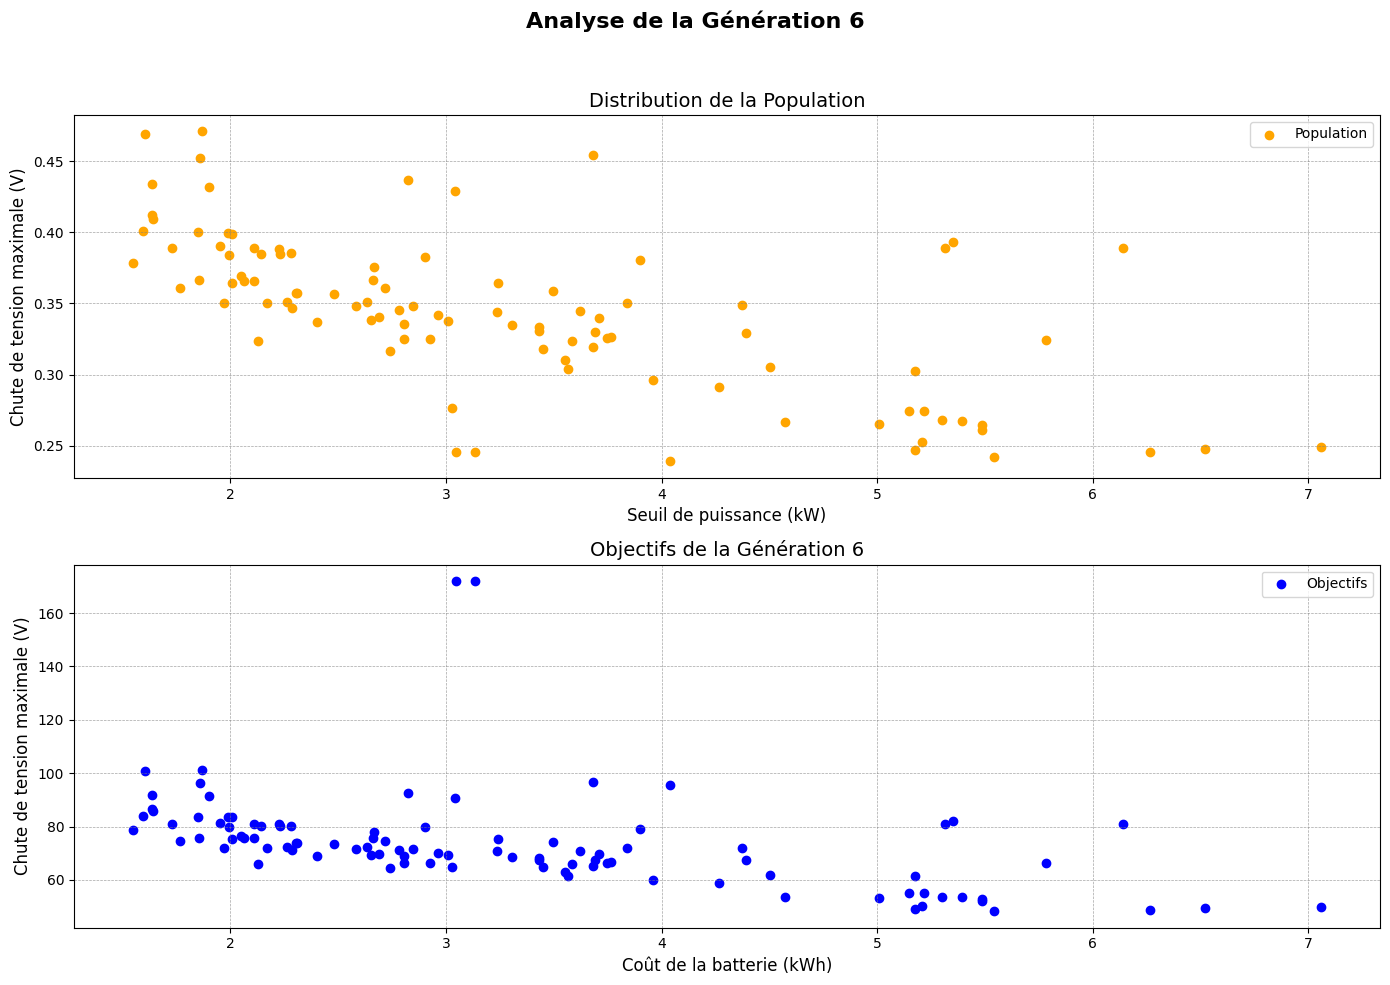

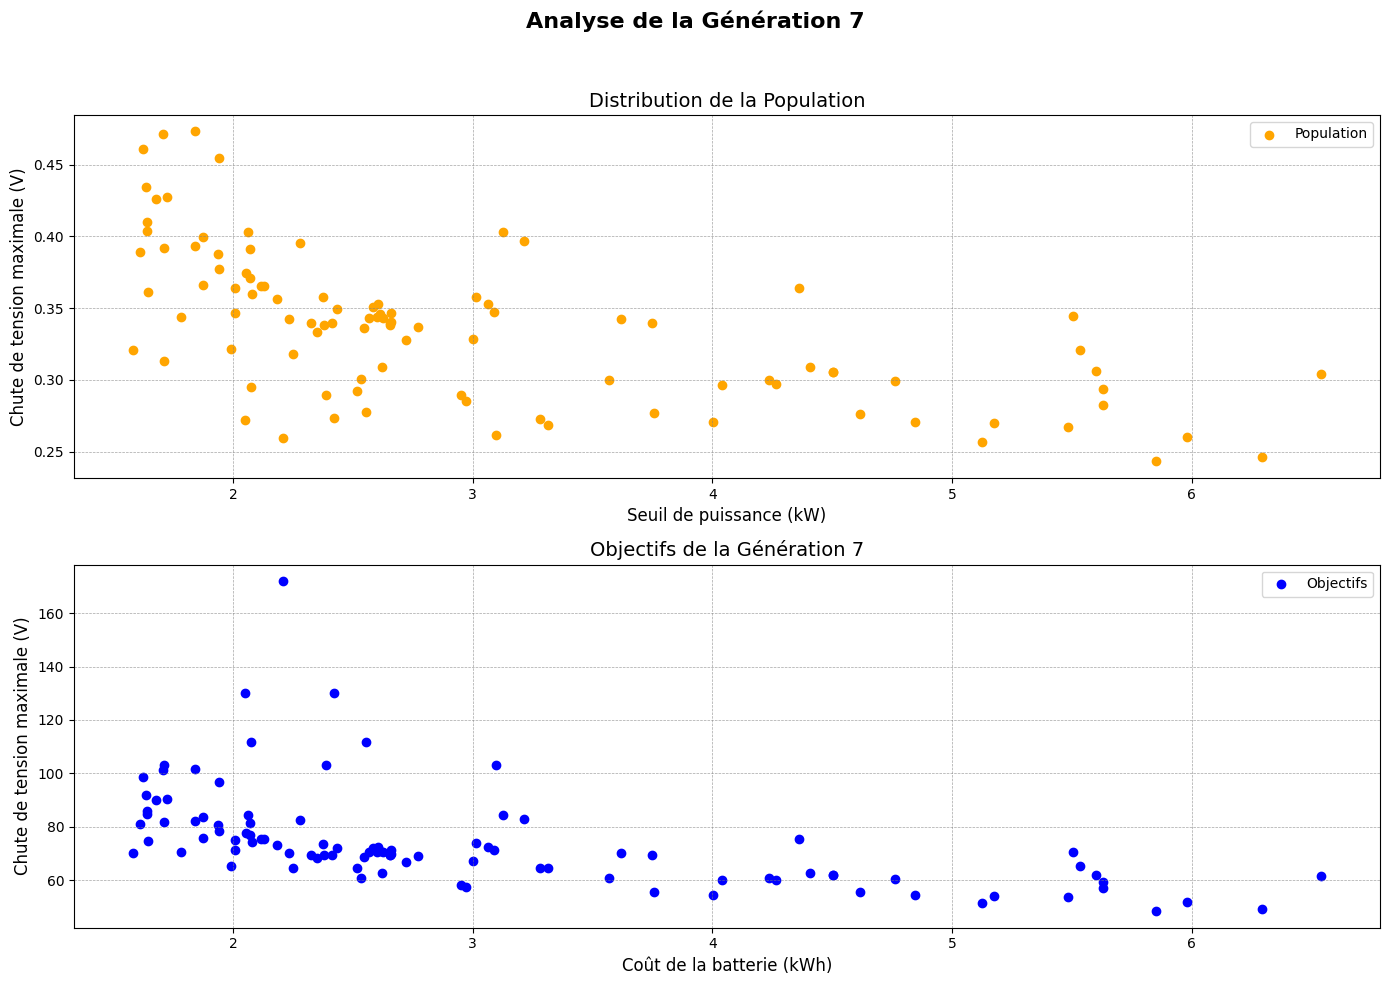

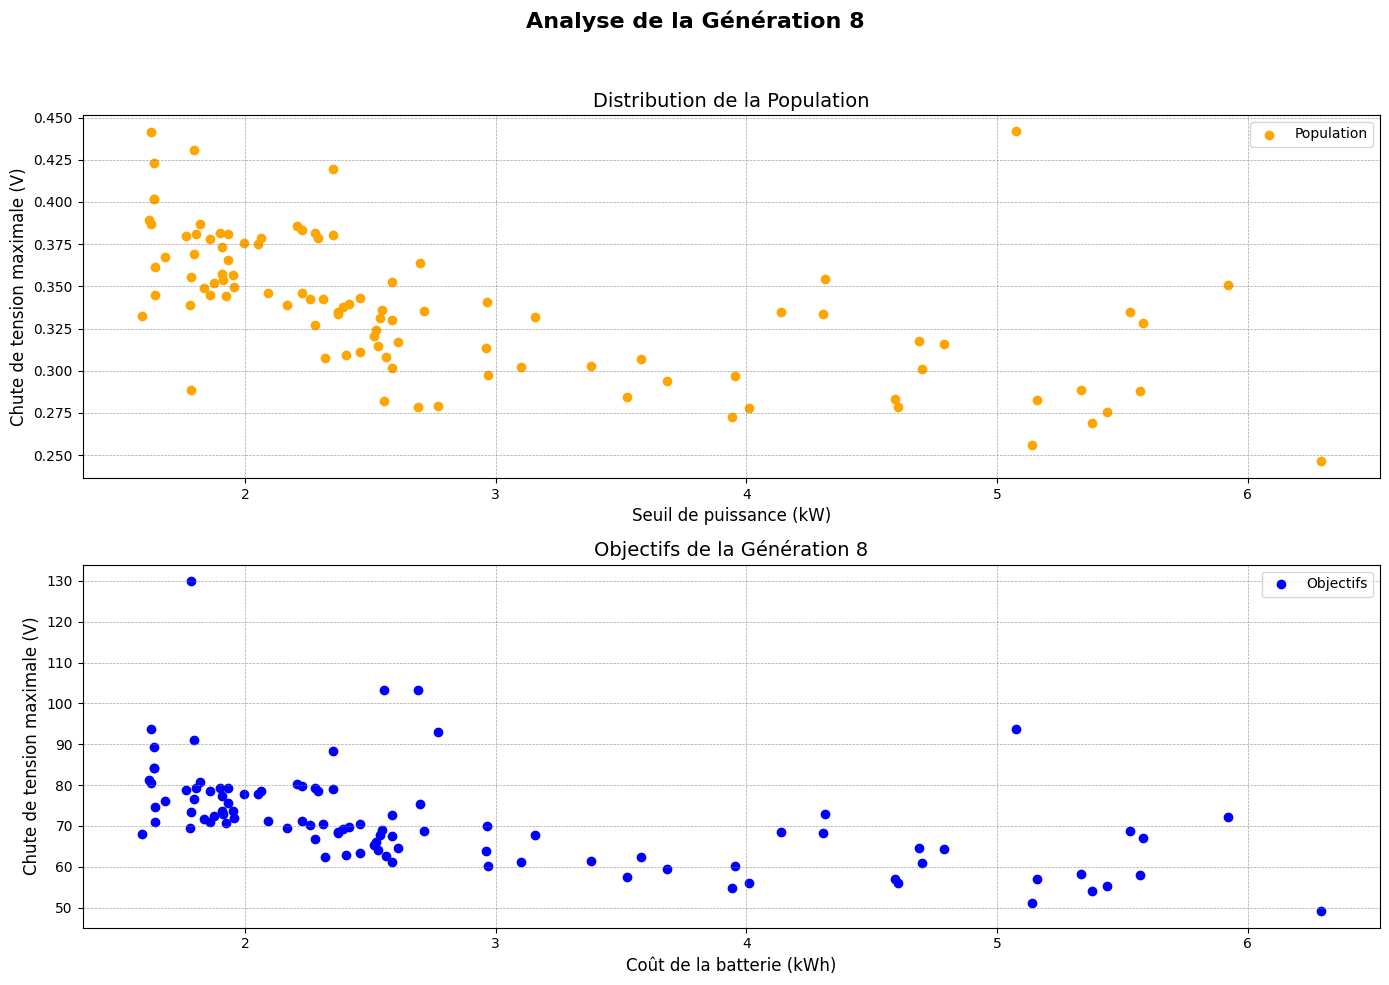

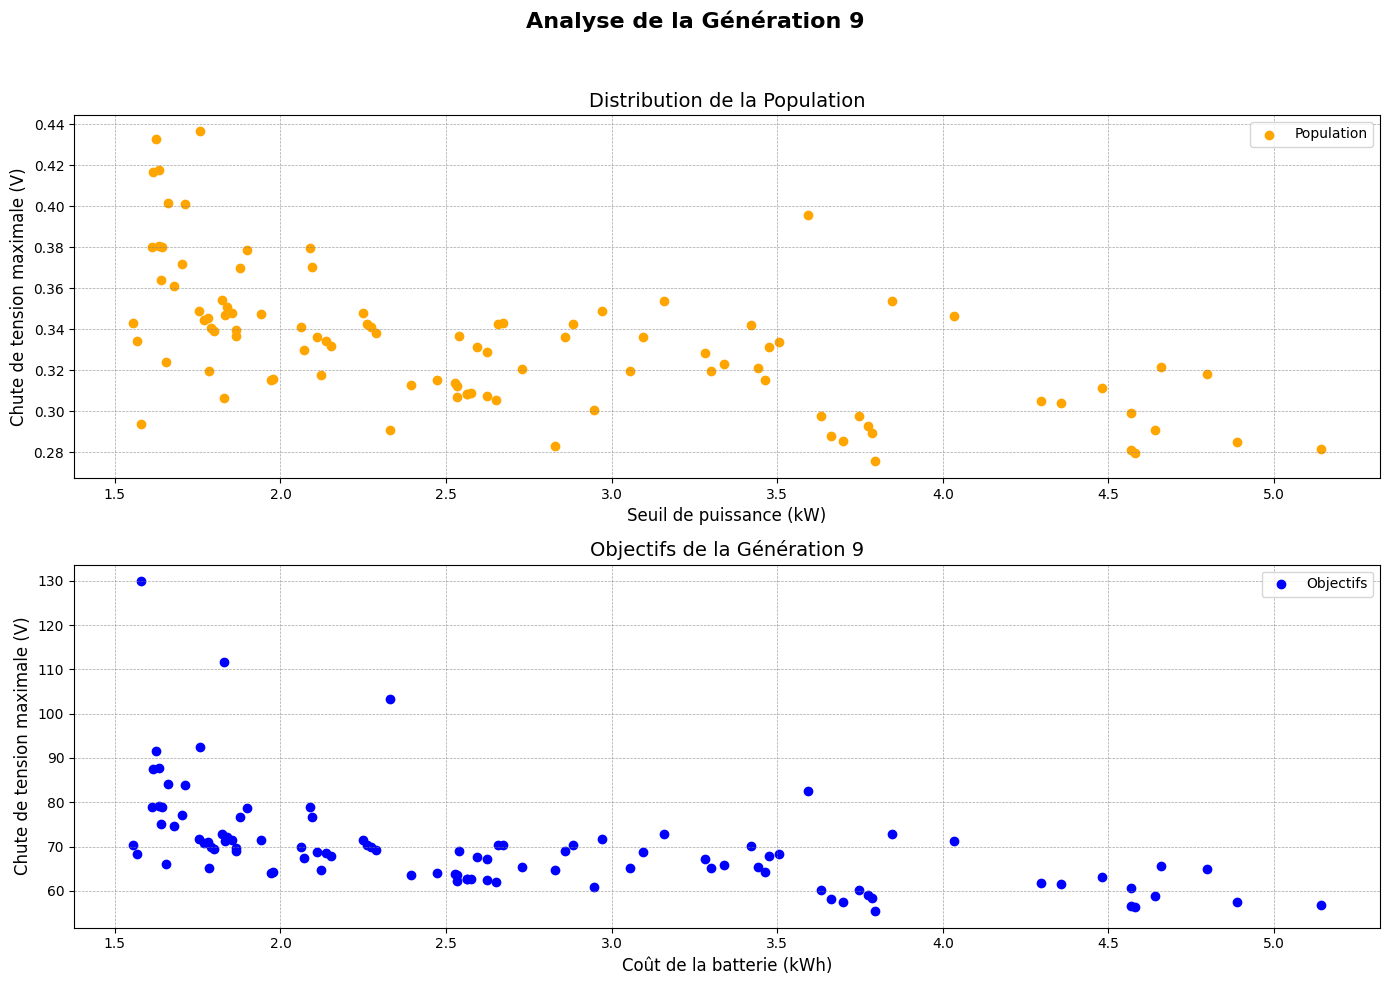

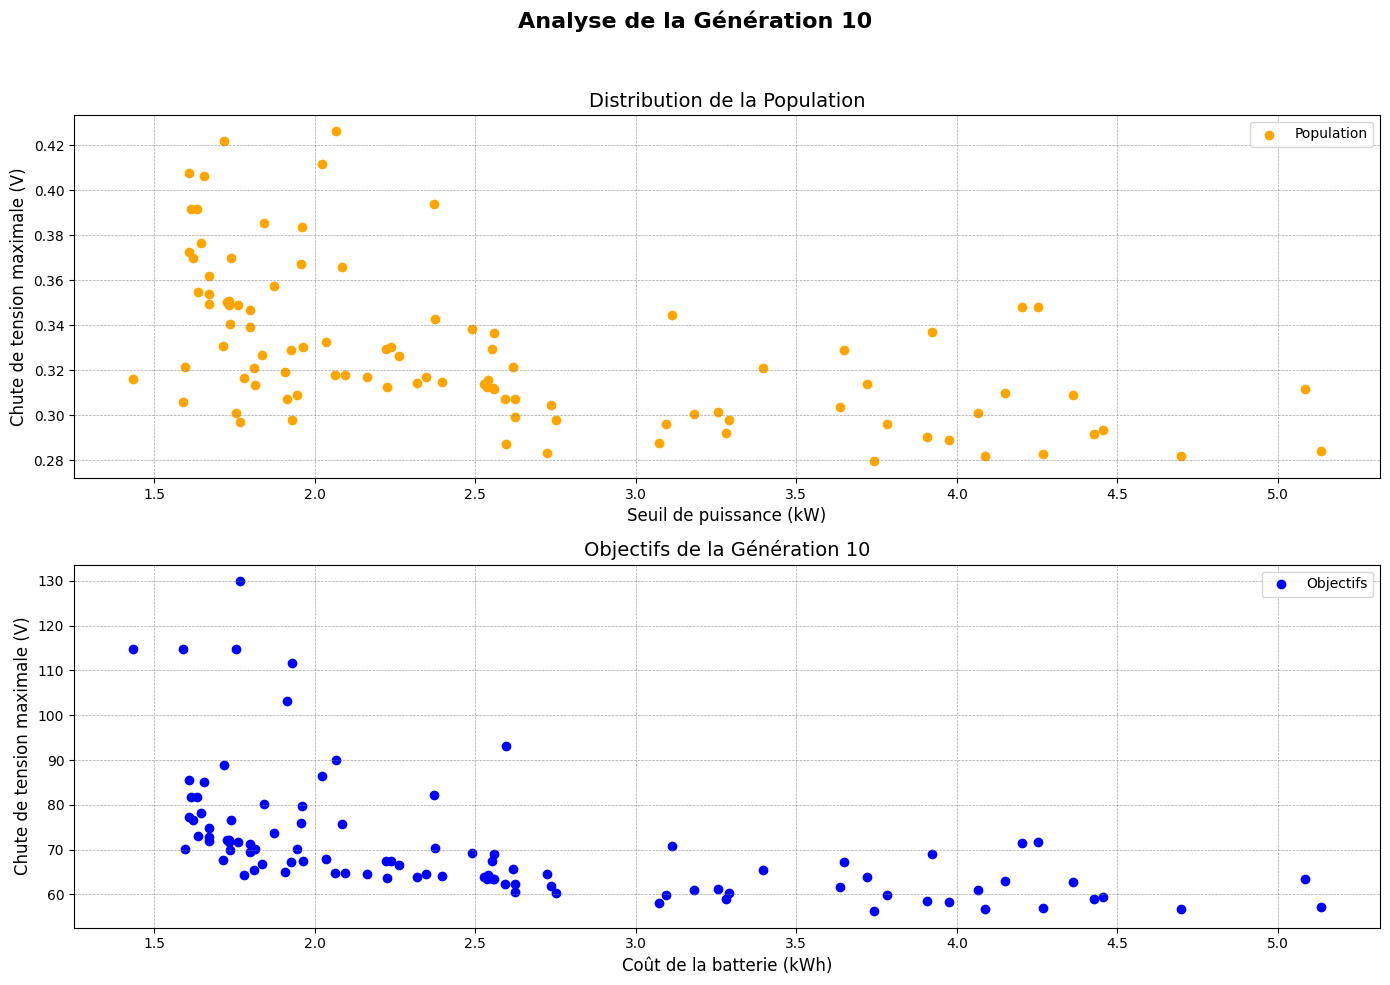

In [116]:
# Paramètres de l'algorithme génétique
population_size = 100  # Taille de la population
generations = 10    # Nombre de générations
mutation_rate = 0.1   # Taux de mutation
tournament_size = 3   # Taille du tournoi pour la sélection
alpha_range = (-0.1, 1.1)  # Plage de l'aléa pour le croisement

# Plages de recherche pour les variables de décision
capacite_batterie_range = np.linspace(0, 14, 200)  # Plage de capacité de la batterie (en kWh)
seuil_puissance_range = np.linspace(0, 1, 200)  # Plage du seuil de puissance (en kW)

# Fonction de simulation pour chaque individu (couple capacité et seuil)
def simulation(capacite_batterie, seuil_puissance):
    _, _, Delta_Vmax, cout_batt = batterie_simulation(capacite_batterie * 3600000,
                                                      P_batt_max=4.5e5,
                                                      P_seuil=seuil_puissance * 10**6,
                                                      position=position, temps=temps)
    return Delta_Vmax, cout_batt*1e-3 / 3600  # Conversion du coût en kWh

# Initialisation de la population
def init_population(pop_size):
    population = []
    for _ in range(pop_size):
        capacite_batterie = random.choice(capacite_batterie_range)
        seuil_puissance = random.choice(seuil_puissance_range)
        population.append([capacite_batterie, seuil_puissance])
    return np.array(population)



# Find the corresponding points in the solution space
def correspondance(dom_objectives,population, objectives  ):
    solutions = []
    
    for pf in dom_objectives:

        for i in range(len(population)):
            if (objectives[i][0] == pf[0]) and (objectives[i][1] == pf[1]):  # Match in objective space
                solutions.append([population[i,0], population[i,1]])  # Add solution space point
                break
    return np.array(solutions)

# Calcul des objectifs (chute de tension et coût) pour chaque individu
def evaluate_population(population):
    return np.array([simulation(individu[0], individu[1]) for individu in population])

def dominates(a, b):
    """
    Returns True if 'a' dominates 'b' under the typical Pareto rule:
    a is better or equal in each objective, and strictly better in at least one.
    """
    return (a[0] <= b[0] and a[1] <= b[1]) and (a[0] < b[0] or a[1] < b[1])


def count_dominators(point, all_points):
    """
    Returns the number of points in 'all_points' that dominate 'point'.
    """
    count = 0
    for other in all_points:
        if dominates(other, point):
            count += 1
    return count



def dominated_points_sorted(points):
    """
    Returns a list of (point, dominance_count) sorted by how many other points dominate each point
    (descending order). Only includes points that are indeed dominated at least by 1 other point.
    """
    # Calculate how many times each point is dominated
    dominated_list = []
    for p in points:
        d_count = count_dominators(p, points)
        # Keep only those that are dominated at least by 1 point
        if d_count > 0:
            dominated_list.append((p, d_count))

    # Sort in descending order by d_count (the number of dominators)
    dominated_list.sort(key=lambda x: x[1], reverse=False)

    dominated_list = [item[0] for item in dominated_list[:30]]


    return np.array(dominated_list)

# Croisement (mélange des gènes des parents)
def crossover(parent1, parent2):
    
    alpha = random.uniform(alpha_range[0], alpha_range[1])  # Facteur de pondération aléatoire
    capacite_batterie = alpha * parent1[0] + (1 - alpha) * parent2[0]
    alpha1 = random.uniform(alpha_range[0], alpha_range[1])  # Facteur de pondération aléatoire
    seuil_puissance = alpha1 * parent1[1] + (1 - alpha1) * parent2[1]
    return [capacite_batterie, seuil_puissance]



# Algorithme génétique
def genetic_algorithm():
    population = init_population(population_size)

    best_solutions = []
    children=[]
    parents=[]
    i=0
    for generation in range(generations):

        i+=1

        

        # Evaluation des objectifs pour chaque individu
        objectives = evaluate_population(population)
        
        plt.figure(figsize=(14, 10))  # Adjust figure size for better spacing

        # --- Population Scatter Plot ---
        plt.subplot(2, 1, 1)
        plt.scatter(population[:, 0], population[:, 1], color='orange', label="Population")
        plt.xlabel("Seuil de puissance (kW)", fontsize=12)
        plt.ylabel("Chute de tension maximale (V)", fontsize=12)
        plt.title("Distribution de la Population", fontsize=14)
        plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.legend(fontsize=10)

        # --- Objectives Scatter Plot ---
        plt.subplot(2, 1, 2)
        plt.scatter(objectives[:, 1], objectives[:, 0], color='blue', label="Objectifs")
        plt.xlabel("Coût de la batterie (kWh)", fontsize=12)
        plt.ylabel("Chute de tension maximale (V)", fontsize=12)
        plt.title(f"Objectifs de la Génération {i}", fontsize=14)
        plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.legend(fontsize=10)

        # Add overall title for the figure
        plt.suptitle(f"Analyse de la Génération {i}", fontsize=16, fontweight='bold')

        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
        plt.show()


        # Tri des solutions par dominance et classement
        dom_objectives = dominated_points_sorted(objectives)


        population_dom  = correspondance(dom_objectives,population, objectives )

        new_population = []
        children=[]
        parents=[]
        while len(new_population) < population_size:
            i1 , i2 = random.randint(0,29),random.randint(0,29)
            
            parent1, parent2 = population_dom[i1,:], population_dom[i2,:]
            child = crossover(parent1, parent2)
            new_population.append(child)
            
        population = np.array(new_population)
       
        
        

  

# Lancer l'algorithme génétique
genetic_algorithm()

## Affichage des résultats (Front de Pareto)
#final_objectives = [obj for generation in best_solutions for obj in generation]
#final_objectives = np.array(final_objectives)#

## Tracer le front de Pareto
#plt.figure(figsize=(10, 5))#

#plt.scatter(final_objectives[:, 1], final_objectives[:, 0], color='orange', label="Front de Pareto")

#plt.legend()
#plt.show()